In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
#from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer, Vars, reset, trackerreset, datareset
from lowEBMs.Packages.RK4 import rk4alg, controlrun
from lowEBMs.Packages.ModelEquation import model_equation
#from lowEBMs.Packages.Variables import 
#from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs.Packages.Optimization import coremodule

from lowEBMs import update_plotstyle, moving_average, constants
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)

In [3]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)
#Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
#np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)
Year_volc_1800_1850=Year_volc[int(1000*365/4):int(1040*365/4)]
Year_volc_1808_1858=Year_volc[int(1008*365/4):int(1048*365/4)]
EVA_GMT_1800_1850=EVA_GMT[int(1000*365/4):int(1040*365/4)]
EVA_GMT_1808_1858=EVA_GMT[int(1008*365/4):int(1048*365/4)]
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')

In [4]:
def coremodule(config,P0,P_pert,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert[0]/P0[0]

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        for i in range(len(data)):
            data[i]=data[i]+elevation
        data_out=data[1][-1]
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        data_out=[data_CTRL[1][-1],np.transpose(data[2][:-1]-data[2][0])]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [6]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b']]
labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func3','f'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#P0=np.array([70*4.2e6,230,2.5])
P0=np.array([50*4.2e6,0.5,1.9e-15,0,1.165,1.165,1.165])
Pmin=np.array([0.5*10*4.2e6,0.4,0.6e-15,-50,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,0.6,5e-15,50,1.2,1.2,1.2])
#P_pert_ralative=[1/10000,1/10000,1/10000,1/10000,1/10000,1/10000]
P_pert=(Pmax-Pmin)/10000
#Pmin=np.array([20*4.2e6,190,1.7])
#Pmax=np.array([120*4.2e6,250,3.3])
#P_pert=(Pmax-Pmin)/100
precision=1e-8
maxlength=int(100)
targetmode='Coupled'
target={'GMT':EVA_GMT_1808_1858,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.33
num_params=7
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Sellers_Offset.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_Offset.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[7943.62996633 7940.59994803 7946.70001985 7848.31946299 8043.98076339
 7638.82612105 8306.13330301 7742.42249419 8172.37927929 7943.05862755
 7944.21317558 7943.53271463 7943.73785158 7941.45043429 7945.84734126]
1e-08
[2.10135218e+08 5.02059593e-01 2.16151958e-15 2.26293045e+00
 1.16501032e+00 1.16500183e+00 1.16503930e+00]
Iteration no.1


[709.93405434 709.8916416  709.97648387 710.44499634 709.4235471
 710.51123001 709.35745884 710.47210515 709.39674363 709.93511802
 709.93299066 709.93435472 709.93375395 709.93941232 709.92869656]
9.980902794630333e-09
[2.10137095e+08 5.02048861e-01 2.16106827e-15 2.25728146e+00
 1.16501030e+00 1.16500183e+00 1.16503920e+00]
Iteration no.2


[708.76401712 708.72156359 708.80648745 709.27380724 708.25466169
 709.33980676 708.18881079 709.30050712 708.22826806 708.76507703
 708.76295721 708.7643163  708.76371793 708.76935624 708.75867821]
3.99900195793859e-06
[2.10889899e+08 4.97758793e-01 1.98068186e-15 4.99317884e-04
 1.16500272e+00 1.16499969e+00 1.16500104e+00]
Iteration no.3


[2501.77148663 2501.32042816 2502.23065882 2483.27859025 2520.5280907
 2449.41343943 2556.26375047 2466.55762012 2537.93266522 2501.63643337
 2501.90582492 2501.74771581 2501.7947518  2501.28719436 2502.25954981]
4.7109061402315125e-08
[2.10984950e+08 4.99605939e-01 2.17795077e-15 1.77018952e+00
 1.16501407e+00 1.16500167e+00 1.16504198e+00]
Iteration no.4


[644.96686905 644.92504717 645.00870745 645.42112308 644.51303527
 645.45343739 644.48092997 645.43414953 644.50033805 644.96775897
 644.96597914 644.96711674 644.96662136 644.97135701 644.96238135]
4.663491125397236e-08
[2.10993598e+08 4.99561361e-01 2.17617338e-15 1.74726941e+00
 1.16501399e+00 1.16500165e+00 1.16504160e+00]
Iteration no.5


[640.93528317 640.89330847 640.97727443 641.38500688 640.48597937
 641.41606032 640.45514724 641.3962633  640.47505575 640.93615767
 640.93440869 640.93552595 640.9350404  640.9396943  640.9308723 ]
3.8929827794842455e-06
[ 2.11718178e+08  4.95877258e-01  2.02956966e-15 -1.40228042e-01
  1.16500791e+00  1.16499996e+00  1.16501091e+00]
Iteration no.6


[1296.50302949 1296.33890924 1296.6660772  1296.73682514 1296.2781104
 1296.29236288 1296.76163257 1296.40325201 1296.6250463  1296.50794436
 1296.4969975  1296.50807054 1296.49798829 1296.58538101 1296.42063344]
2.8083877739997683e-06
[2.13754883e+08 4.94521206e-01 2.08121819e-15 1.87605845e-01
 1.16498043e+00 1.16497465e+00 1.16459740e+00]
Iteration no.7


[1209.20773981 1209.06982869 1209.34568322 1209.26215304 1209.15390288
 1208.33451572 1210.08371035 1208.58126233 1209.83629451 1209.20450305
 1209.21097663 1209.2067657  1209.20871394 1209.19577612 1209.21970458]
8.381429675642408e-07
[2.14267389e+08 4.94425702e-01 2.13867409e-15 7.41235525e-01
 1.16498528e+00 1.16497611e+00 1.16461532e+00]
Iteration no.8


[980.11208547 979.99975669 980.22370472 977.22914354 983.00128119
 973.3868892  986.88478053 974.98844059 985.26141977 980.0849548
 980.13921705 980.10375788 980.1204131  979.95761558 980.26510811]
1.1397774573965343e-07
[2.14323970e+08 4.95118223e-01 2.19896675e-15 1.35749395e+00
 1.16499081e+00 1.16497781e+00 1.16464664e+00]
Iteration no.9


[559.6409173  559.59507852 559.68623901 559.80233978 559.48263692
 559.61238328 559.67952536 559.68589155 559.60341678 559.63907273
 559.64276194 559.64056504 559.64126957 559.63746044 559.64420794]
1.1394242088687713e-07
[2.14346994e+08 4.95079878e-01 2.19926657e-15 1.35254796e+00
 1.16499118e+00 1.16497788e+00 1.16464733e+00]
Iteration no.10


[559.26739652 559.22204444 559.31330306 559.42493864 559.11352211
 559.2317407  559.31365082 559.30597486 559.23592204 559.26604963
 559.26927955 559.26703595 559.26775709 559.26435484 559.27134145]
1.107595200926987e-07
[2.14369400e+08 4.95043571e-01 2.19962211e-15 1.34846427e+00
 1.16499150e+00 1.16497795e+00 1.16464802e+00]
Iteration no.11


[558.91236997 558.86682358 558.95829627 559.06769651 558.76053484
 558.8725744  558.96329338 558.94800179 558.8845664  558.91082415
 558.91427819 558.91200395 558.91273599 558.90871258 558.91675457]
1.1761915057750401e-07
[2.14393249e+08 4.95005541e-01 2.20004029e-15 1.34453732e+00
 1.16499187e+00 1.16497803e+00 1.16464887e+00]
Iteration no.12


[558.53901199 558.49346185 558.58494134 558.6923198  558.38883261
 558.49454379 558.59263159 558.57167606 558.5138121  558.53744686
 558.54093884 558.53864194 558.53938205 558.53493319 558.54345432]
2.5529833108063346e-07
[2.14445018e+08 4.94923983e-01 2.20102167e-15 1.33676228e+00
 1.16499266e+00 1.16497820e+00 1.16465081e+00]
Iteration no.13


[557.73308414 557.68773199 557.7786314  557.88296062 557.58614272
 557.68381315 557.79219116 557.76045482 557.712448   557.73166585
 557.73467936 557.73270806 557.73346021 557.72909367 557.73725469]
1.3505312317508902e-07
[2.14472230e+08 4.94881787e-01 2.20159529e-15 1.33334993e+00
 1.16499303e+00 1.16497829e+00 1.16465180e+00]
Iteration no.14


[557.31012179 557.26426882 557.35599236 557.4590726  557.16463583
 557.2601876  557.37003995 557.33697936 557.29016193 557.30816333
 557.31208032 557.30974486 557.31049873 557.30594039 557.31394647]
2.094378693661354e-06
[2.14898061e+08 4.94232669e-01 2.21061190e-15 1.28174286e+00
 1.16500036e+00 1.16497970e+00 1.16466678e+00]
Iteration no.15


[550.8136513  550.76840802 550.85891195 550.95586062 550.67362547
 550.75396195 550.88230822 550.83294232 550.80027873 550.81165548
 550.81564718 550.8132662  550.81403641 550.80933637 550.81761512]
2.265644267295587e-06
[2.15352587e+08 4.93559570e-01 2.22200792e-15 1.24279335e+00
 1.16500844e+00 1.16498126e+00 1.16468355e+00]
Iteration no.16


[543.96033939 543.9163751  544.00432069 544.12342324 543.79957707
 543.94249033 543.98736099 544.01522747 543.91191181 543.9585881
 543.96209073 543.96000714 543.96067164 543.95675887 543.96356838]
1.4342196573434249e-06
[2.15632183e+08 4.93070658e-01 2.22452999e-15 1.16480527e+00
 1.16501293e+00 1.16498211e+00 1.16469227e+00]
Iteration no.17


[540.05800554 540.01303994 540.10298823 540.15280168 539.96530882
 539.91584733 540.20737439 540.00776375 540.11284644 540.05557443
 540.06010522 540.05752582 540.05848525 540.05231418 540.06283874]
2.0509059889230426e-07
[2.15673075e+08 4.93030181e-01 2.22687315e-15 1.17614815e+00
 1.16501376e+00 1.16498229e+00 1.16469420e+00]
Iteration no.18


[539.10431559 539.05993468 539.14837466 539.22246561 538.98753044
 539.00744623 539.20891388 539.09242591 539.12199303 539.10213954
 539.10615306 539.10389124 539.1044009  539.09907073 539.10922368]
4.892068075968024e-07
[2.15768980e+08 4.92909200e-01 2.23073572e-15 1.18376101e+00
 1.16501552e+00 1.16498251e+00 1.16469864e+00]
Iteration no.19


[537.5557247  537.51214306 537.59863109 537.70264455 537.40970821
 537.51243924 537.6068936  537.58902367 537.52689603 537.55384846
 537.5569091  537.55536533 537.55573791 537.55139387 537.55936646]
5.600515744305446e-07
[2.15876350e+08 4.92736506e-01 2.23280886e-15 1.16544802e+00
 1.16501705e+00 1.16498270e+00 1.16470263e+00]
Iteration no.20


[535.90545937 535.86188995 535.94904561 536.0460031  535.76822534
 535.849651   535.97084124 535.92783192 535.88893187 535.90350974
 535.90740906 535.90508409 535.90583465 535.90158808 535.90967656]
2.811379709568576e-07
[2.15930665e+08 4.92654302e-01 2.23414412e-15 1.15969208e+00
 1.16501803e+00 1.16498289e+00 1.16470467e+00]
Iteration no.21


[535.08167503 535.03943076 535.12462439 535.22323175 534.9434205
 535.02795183 535.14423254 535.10712176 535.06308392 535.08094469
 535.08309273 535.08130321 535.08153036 535.07837037 535.08567235]
3.033227954716482e-06
[2.16503477e+08 4.91760900e-01 2.24796677e-15 1.08938850e+00
 1.16502385e+00 1.16498350e+00 1.16472446e+00]
Iteration no.22


[526.29649285 526.25407398 526.33859074 526.43849871 526.15636113
 526.24898689 526.3518583  526.32647744 526.27184342 526.29461304
 526.29769773 526.29613259 526.29685311 526.29229737 526.30018487]
1.6324723494437163e-05
[2.19561841e+08 4.86912671e-01 2.31378086e-15 6.19975176e-01
 1.16506886e+00 1.16499401e+00 1.16483954e+00]
Iteration no.23


[484.79588287 484.75570543 484.83535609 484.80402642 484.80203005
 484.55087572 485.07987611 484.64254212 484.98126504 484.79299604
 484.79855899 484.7951173  484.79664845 484.78768992 484.8039811 ]
5.326719354822541e-07
[2.19655889e+08 4.86911551e-01 2.32482405e-15 7.14937384e-01
 1.16507150e+00 1.16499474e+00 1.16484730e+00]
Iteration no.24


[480.46601573 480.42850279 480.50354349 480.59692648 480.33777155
 480.42017014 480.51799493 480.49900517 480.43843329 480.46424545
 480.46778607 480.46567906 480.46635241 480.4625175  480.46982194]
5.540177564136686e-07
[2.19748044e+08 4.86760418e-01 2.32694803e-15 6.97275334e-01
 1.16507326e+00 1.16499508e+00 1.16485091e+00]
Iteration no.25


[479.11714734 479.07966774 479.15464172 479.24224681 478.99377594
 479.06292327 479.17687748 479.14250943 479.09705257 479.11532861
 479.11896614 479.11680012 479.11749457 479.11349245 479.12110697]
4.226107676828899e-07
[2.19818279e+08 4.86649885e-01 2.32883536e-15 6.87164514e-01
 1.16507463e+00 1.16499534e+00 1.16485379e+00]
Iteration no.26


[478.09692542 478.05985202 478.13431534 478.22247614 477.97433598
 478.04300509 478.15692068 478.12254423 478.07793239 478.09571152
 478.09874299 478.09657846 478.09727238 478.09327159 478.10118539]
5.8755153351579125e-05
[ 2.29516426e+08  4.71303030e-01  2.59114096e-15 -6.92401382e-01
  1.16523382e+00  1.16503178e+00  1.16526936e+00]
Iteration no.27


[391.8210877  391.78913237 391.85305561 391.21475589 392.43239734
 390.9155469  392.73497441 390.80258297 392.85197868 391.81179836
 391.83039918 391.81924033 391.82293502 391.79481736 391.84774295]
3.89459575530399e-07
[ 2.29571611e+08  4.71802211e-01  2.61891094e-15 -2.72318864e-01
  1.16524029e+00  1.16503306e+00  1.16528778e+00]
Iteration no.28


[355.55987785 355.53598495 355.58378124 355.71171148 355.4096662
 355.58483428 355.53647278 355.67514091 355.44831154 355.55899851
 355.56075723 355.55973784 355.56001786 355.55861108 355.56091622]
3.6199004509225897e-07
[ 2.29609963e+08  4.71687119e-01  2.61822486e-15 -3.15534640e-01
  1.16524086e+00  1.16503315e+00  1.16528853e+00]
Iteration no.29


[354.28538238 354.26113698 354.30963832 354.41635052 354.15601425
 354.28575934 354.28736288 354.36957098 354.20475115 354.28429477
 354.28647003 354.2851969  354.28556786 354.28346602 354.28730029]
9.534392627624386e-07
[ 2.29712469e+08  4.71425840e-01  2.61828478e-15 -3.98242904e-01
  1.16524272e+00  1.16503347e+00  1.16529179e+00]
Iteration no.30


[352.30725947 352.28249408 352.33203542 352.40061606 352.21547151
 352.26405494 352.35233214 352.33589379 352.28188131 352.30579088
 352.30851874 352.30699061 352.30752834 352.30415252 352.31015914]
9.034486949408767e-07
[ 2.29811683e+08  4.71249768e-01  2.62141036e-15 -4.23925798e-01
  1.16524492e+00  1.16503390e+00  1.16529664e+00]
Iteration no.31


[351.05915377 351.0344076  351.08391047 351.14599485 350.97368934
 351.00884094 351.11163606 351.07862968 351.04277615 351.05762255
 351.06068505 351.05887123 351.05943632 351.05585005 351.0622527 ]
2.561816829365725e-07
[ 2.29839794e+08  4.71203303e-01  2.62244240e-15 -4.28760018e-01
  1.16524562e+00  1.16503403e+00  1.16529811e+00]
Iteration no.32


[350.71242939 350.68771108 350.73715822 350.79880949 350.62673311
 350.66103165 350.7649537  350.73135081 350.696617   350.7108959
 350.71396294 350.71214636 350.71271243 350.70911802 350.71553637]
1.2899922850977268e-05
[ 2.31253726e+08  4.68866701e-01  2.67498037e-15 -6.64582872e-01
  1.16528098e+00  1.16504056e+00  1.16537211e+00]
Iteration no.33


[333.59116245 333.56734019 333.61481208 333.63985374 333.54812246
 333.50653305 333.68277591 333.5629481  333.6314732  333.58943364
 333.5931344  333.59074942 333.59139209 333.58714549 333.59542922]
1.6105244819560362e-06
[ 2.31423201e+08  4.68711190e-01  2.68610427e-15 -6.06497947e-01
  1.16528631e+00  1.16504149e+00  1.16538403e+00]
Iteration no.34


[331.94450834 331.9219179  331.9671087  332.04887604 331.84176767
 331.92131    331.96877579 331.99747937 331.89443851 331.94327773
 331.945739   331.94429231 331.94472437 331.94231793 331.94690039]
1.1831932571358168e-06
[ 2.31541725e+08  4.68453243e-01  2.68830525e-15 -6.70664923e-01
  1.16528891e+00  1.16504194e+00  1.16538888e+00]
Iteration no.35


[330.28593659 330.26312803 330.30875505 330.36762875 330.20625823
 330.23866871 330.33611027 330.30526664 330.27008996 330.28464465
 330.2874183  330.28566566 330.28620753 330.28361298 330.2891124 ]
8.241973576632691e-07
[ 2.31625084e+08  4.68313242e-01  2.69145266e-15 -6.85924146e-01
  1.16529095e+00  1.16504234e+00  1.16539293e+00]
Iteration no.36


[329.3000563  329.27731542 329.32280705 329.37932739 329.13371925
 329.25005225 329.2603446  329.31668578 329.17433222 329.29874362
 329.30155722 329.29978123 329.30033138 329.29682155 329.3031046 ]
1.422628036106399e-07
[ 2.31639430e+08  4.68276462e-01  2.69151004e-15 -6.96582891e-01
  1.16529131e+00  1.16504241e+00  1.16539373e+00]
Iteration no.37


[328.96866404 328.94640524 328.99125212 329.06609737 328.88357123
 328.93772489 329.01297074 329.01551587 328.9474329  328.96776486
 328.97045105 328.96856091 328.96899889 328.96617658 328.97138849]
1.594532876045173e-07
[ 2.31655281e+08  4.68245826e-01  2.69198026e-15 -7.02296604e-01
  1.16529170e+00  1.16504247e+00  1.16539447e+00]
Iteration no.38


[328.76937131 328.74656083 328.79195945 328.85254403 328.69506878
 328.72335696 328.82500893 328.79406155 328.76287027 328.76793223
 328.77075667 328.76902168 328.76972095 328.76644802 328.77272345]
5.456936488311396e-08
[ 2.31660772e+08  4.68236781e-01  2.69219765e-15 -7.03192440e-01
  1.16529183e+00  1.16504251e+00  1.16539478e+00]
Iteration no.39


[328.70440396 328.68182803 328.72699077 328.78681054 328.63028103
 328.65806782 328.75991372 328.72765182 328.69815259 328.70291397
 328.70579226 328.70405382 328.70475412 328.70147282 328.70743428]
2.174249574638121e-06
[ 2.31878438e+08  4.67878534e-01  2.70087588e-15 -7.36949643e-01
  1.16529743e+00  1.16504387e+00  1.16540636e+00]
Iteration no.40


[326.14392277 326.12145134 326.16675608 326.21136869 326.08297735
 326.08284707 326.21264542 326.14548123 326.15598156 326.14263217
 326.14586355 326.14355591 326.14428964 326.14056723 326.14780664]
1.2109134480771854e-06
[ 2.32000045e+08  4.67714881e-01  2.70703560e-15 -7.30257544e-01
  1.16530092e+00  1.16504466e+00  1.16541420e+00]
Iteration no.41


[324.90665386 324.88437221 324.92894525 324.98839689 324.7993162
 324.86128747 324.92287829 324.92867114 324.81747387 324.90521021
 324.90809758 324.90639147 324.90691627 324.90359214 324.909531  ]
7.18557102223317e-07
[ 2.32071041e+08  4.67571864e-01  2.70877002e-15 -7.72311012e-01
  1.16530278e+00  1.16504500e+00  1.16541801e+00]
Iteration no.42


[323.92058499 323.89798997 323.94351691 323.97753613 323.86868861
 323.8504164  323.99760992 323.90835315 323.94464284 323.91900131
 323.92235102 323.92020592 323.92096406 323.9167598  323.92441663]
2.3991983163773975e-07
[ 2.32095253e+08  4.67544375e-01  2.71015401e-15 -7.67728581e-01
  1.16530350e+00  1.16504516e+00  1.16541965e+00]
Iteration no.43


[323.61121683 323.58906036 323.63338893 323.68431559 323.54466786
 323.55722223 323.67252998 323.62280431 323.61360486 323.60978699
 323.61262681 323.61086492 323.61156875 323.60782365 323.61443901]
4.774202474524557e-07
[ 2.32142165e+08  4.67474196e-01  2.71231145e-15 -7.70040162e-01
  1.16530471e+00  1.16504546e+00  1.16542247e+00]
Iteration no.44


[323.06204674 323.04026589 323.08430197 323.14572022 322.98696567
 323.01831205 323.1142243  323.08875143 323.05211306 323.06079995
 323.06361921 323.06170966 323.06238383 323.05908608 323.06506554]
7.611058451242557e-07
[ 2.32216459e+08  4.67347007e-01  2.71517231e-15 -7.84716833e-01
  1.16530663e+00  1.16504592e+00  1.16542654e+00]
Iteration no.45


[322.19337712 322.17109007 322.21567866 322.26329612 322.12945894
 322.13664904 322.2562347  322.19984333 322.19948682 322.1917252
 322.19484965 322.19302304 322.1937312  322.18971388 322.19619211]
2.676843542705916e-07
[ 2.32242917e+08  4.67309296e-01  2.71642684e-15 -7.84767060e-01
  1.16530737e+00  1.16504609e+00  1.16542809e+00]
Iteration no.46


[321.88477781 321.86259624 321.90720381 321.9620015  321.81454852
 321.83604332 321.94118489 321.90349248 321.88101014 321.88318489
 321.88637578 321.88443553 321.88512011 321.88145798 321.88782074]
6.554875247220792e-07
[ 2.32307731e+08  4.67207555e-01  2.71912780e-15 -7.92523318e-01
  1.16530924e+00  1.16504649e+00  1.16543182e+00]
Iteration no.47


[321.14201688 321.12002888 321.16435819 321.22076113 321.07099766
 321.09458934 321.19707319 321.16247049 321.13676185 321.14077654
 321.14353415 321.14202226 321.14223983 321.13907868 321.14541614]
7.271198796833093e-06
[ 2.33022223e+08  4.66061281e-01  2.74833163e-15 -8.90908917e-01
  1.16532716e+00  1.16504791e+00  1.16547300e+00]
Iteration no.48


[313.09017366 313.0691995  313.11198387 313.14476591 313.04098034
 313.02247659 313.16343806 313.07820061 313.1127945  313.08941503
 313.09193114 313.0898107  313.09036381 313.08707806 313.09427321]
2.024528785626045e-06
[ 2.33214227e+08  4.65840106e-01  2.75951577e-15 -8.54047694e-01
  1.16533172e+00  1.16504891e+00  1.16548602e+00]
Iteration no.49


[311.33094873 311.31021178 311.35169498 311.42798521 311.23525371
 311.30722904 311.35624621 311.38083406 311.28394761 311.32995198
 311.33212908 311.3307446  311.33115285 311.32869439 311.33320429]
1.3317105612097046e-06
[ 2.33336684e+08  4.65569934e-01  2.76207399e-15 -9.21955433e-01
  1.16533431e+00  1.16504939e+00  1.16549139e+00]
Iteration no.50


[309.53401466 309.51290449 309.55513534 309.59854023 309.47465959
 309.47786385 309.59503019 309.53816754 309.54028299 309.53265126
 309.53560063 309.53367745 309.53412722 309.53071972 309.53748606]
6.340001049321548e-07
[ 2.33396033e+08  4.65487260e-01  2.76498518e-15 -9.21249539e-01
  1.16533598e+00  1.16504965e+00  1.16549523e+00]
Iteration no.51


[308.87601948 308.85504159 308.89647884 308.95483349 308.80308258
 308.83439824 308.92335804 308.90153988 308.86297953 308.87454597
 308.87731998 308.8757072  308.87624524 308.87328773 308.87875187]
8.261075446107693e-07
[ 2.33471914e+08  4.65355300e-01  2.76786528e-15 -9.38015325e-01
  1.16533803e+00  1.16505004e+00  1.16549926e+00]
Iteration no.52


[308.03105478 308.01008376 308.05203624 308.09533677 307.97200602
 307.97519896 308.09190178 308.0353761  308.03731595 308.02981916
 308.0324122  308.03094281 308.03138996 308.02778329 308.03428092]
2.164459683050779e-07
[ 2.33492042e+08  4.65327200e-01  2.76885523e-15 -9.37794339e-01
  1.16533853e+00  1.16505013e+00  1.16550052e+00]
Iteration no.53


[307.80459522 307.78400088 307.82550566 307.8732818  307.74156464
 307.75293063 307.86165267 307.81502587 307.80525605 307.80344656
 307.80613588 307.80426815 307.80492229 307.8017924  307.80776008]
9.306660586484738e-07
[ 2.33577665e+08  4.65198164e-01  2.77282065e-15 -9.42579836e-01
  1.16534076e+00  1.16505067e+00  1.16550548e+00]
Iteration no.54


[306.8553465  306.83464179 306.87584394 306.93281436 306.78326164
 306.8135207  306.90270806 306.88014989 306.84264463 306.85388766
 306.85602653 306.85503704 306.85543438 306.85203765 306.85805295]
1.4839374739738562e-06
[ 2.33713195e+08  4.64964557e-01  2.77800743e-15 -9.71872180e-01
  1.16534360e+00  1.16505120e+00  1.16551346e+00]
Iteration no.55


[305.38300316 305.36173988 305.40383351 305.4377442  305.33262472
 305.31954311 305.45041929 305.37472412 305.40044839 305.38131396
 305.38463992 305.38265652 305.38312863 305.3795614  305.38617511]
2.2692951117463332e-07
[ 2.33734370e+08  4.64939446e-01  2.77917136e-15 -9.68799761e-01
  1.16534428e+00  1.16505130e+00  1.16551480e+00]
Iteration no.56


[305.13508304 305.1146015  305.15612497 305.19845184 305.07672099
 305.07965749 305.19508662 305.13902735 305.14148191 305.13390798
 305.13686619 305.13475218 305.1354139  305.13191067 305.13852897]
7.058436011241039e-07
[ 2.33799338e+08  4.64849001e-01  2.78236439e-15 -9.67887899e-01
  1.16534614e+00  1.16505172e+00  1.16551897e+00]
Iteration no.57


[304.42650627 304.40583209 304.44707869 304.50390626 304.35494564
 304.38508545 304.4735348  304.45137036 304.41367092 304.42514422
 304.42764901 304.42650189 304.42672635 304.42376755 304.4292984 ]
9.09271945314714e-07
[ 2.33882473e+08  4.64706427e-01  2.78551625e-15 -9.85929501e-01
  1.16534818e+00  1.16505190e+00  1.16552347e+00]
Iteration no.58


[303.52575526 303.50519928 303.54654107 303.58791312 303.46822287
 303.47038584 303.58576603 303.52869345 303.53231607 303.52436567
 303.5273137  303.52564431 303.52608453 303.52254954 303.52891375]
1.7828969993332664e-07
[ 2.33898811e+08  4.64683964e-01  2.78632244e-15 -9.85589566e-01
  1.16534865e+00  1.16505197e+00  1.16552448e+00]
Iteration no.59


[303.34518099 303.3244627  303.36569163 303.41050978 303.28435603
 303.2929619  303.40267923 303.35340043 303.34759253 303.34343438
 303.34671042 303.34485808 303.34539528 303.3428908  303.34825515]
9.106975648987492e-07
[ 2.33982041e+08  4.64563030e-01  2.79023830e-15 -9.88373379e-01
  1.16535131e+00  1.16505240e+00  1.16552885e+00]
Iteration no.60


[302.44857357 302.42806487 302.46844185 302.52495181 302.3771328
 302.40664924 302.49470763 302.4723048  302.43521975 302.44692486
 302.4493573  302.44827143 302.44887571 302.44530793 302.4508459 ]
1.2819988719424726e-06
[ 2.34096783e+08  4.64363552e-01  2.79466252e-15 -1.01339601e+00
  1.16535410e+00  1.16505310e+00  1.16553519e+00]
Iteration no.61


[301.20709855 301.1862675  301.22766931 301.26386322 301.15460119
 301.14747051 301.27036205 301.20348037 301.21975117 301.20546139
 301.20868444 301.20693006 301.20732426 301.20380875 301.20995531]
1.894633081821327e-07
[ 2.34114170e+08  4.64341761e-01  2.79557501e-15 -1.01177352e+00
  1.16535465e+00  1.16505316e+00  1.16553624e+00]
Iteration no.62


[301.01269385 300.99226809 301.03312971 301.07481482 300.95550704
 300.95831824 301.0712364  301.01666579 301.01816574 301.0115969
 301.01434161 301.01247812 301.0129096  301.009434   301.01612521]
8.391454038841101e-07
[ 2.34190177e+08  4.64236375e-01  2.79928847e-15 -1.01111106e+00
  1.16535670e+00  1.16505349e+00  1.16554125e+00]
Iteration no.63


[300.20218182 300.18189085 300.2222694  300.27823635 300.13140846
 300.16179891 300.2474452  300.227244   300.18853277 300.20055065
 300.20360009 300.2018837  300.20247993 300.19961355 300.20492537]
1.0469607152990117e-06
[ 2.34283886e+08  4.64074562e-01  2.80280260e-15 -1.03244219e+00
  1.16535956e+00  1.16505405e+00  1.16554622e+00]
Iteration no.64


[299.20747062 299.18728811 299.22766228 299.26655427 299.15322087
 299.1511603  299.26822516 299.20737024 299.21695596 299.20608192
 299.2090244  299.20714332 299.20779792 299.20405977 299.21105021]
1.5355750728239273e-07
[ 2.34297629e+08  4.64056242e-01  2.80350709e-15 -1.03166747e+00
  1.16535996e+00  1.16505414e+00  1.16554718e+00]
Iteration no.65


[299.05567895 299.03511709 299.07560449 299.11728289 298.99785322
 299.00164455 299.11295187 299.05977439 299.06018488 299.05393867
 299.05655019 299.05535798 299.05578496 299.05218996 299.0585762 ]
9.3917444478835e-07
[ 2.34381917e+08  4.63938174e-01  2.80760392e-15 -1.03146457e+00
  1.16536215e+00  1.16505449e+00  1.16555254e+00]
Iteration no.66


[298.16366582 298.14399681 298.18366606 298.2398638  298.09283807
 298.12383561 298.2081651  298.18891318 298.14912736 298.16221875
 298.16506834 298.16337161 298.16396003 298.16114268 298.16606447]
1.1279540870686934e-06
[ 2.34481102e+08  4.63763607e-01  2.81133170e-15 -1.05508382e+00
  1.16536503e+00  1.16505509e+00  1.16555751e+00]
Iteration no.67


[297.11069571 297.0905252  297.13062965 297.16728558 297.057928
 297.05245676 297.17197582 297.10717133 297.12215298 297.10930195
 297.11179206 297.11036829 297.11085987 297.10738357 297.11352435]
1.1361656254657354e-07
[ 2.34491203e+08  4.63750528e-01  2.81186388e-15 -1.05418794e+00
  1.16536528e+00  1.16505514e+00  1.16555813e+00]
Iteration no.68


[296.99771632 296.97780071 297.01812109 297.05677553 296.9431499
 296.94227733 297.05685527 296.99909787 297.00555089 296.99639715
 296.99930056 296.99739406 296.9979567  296.99479761 297.00111763]
9.47069825076962e-07
[ 2.34575849e+08  4.63637253e-01  2.81611654e-15 -1.05097138e+00
  1.16536774e+00  1.16505561e+00  1.16556348e+00]
Iteration no.69


[296.11306364 296.09343681 296.1327504  296.19036357 296.04129269
 296.07536742 296.15565949 296.14085303 296.09604303 296.11227819
 296.11448497 296.11298828 296.11318612 296.11061526 296.11594201]
9.926909937564642e-07
[ 2.34662357e+08  4.63481483e-01  2.81924021e-15 -1.07438322e+00
  1.16536970e+00  1.16505579e+00  1.16556820e+00]
Iteration no.70


[295.20039832 295.18035703 295.22044893 295.25687785 295.14844345
 295.14298928 295.26104888 295.19781372 295.21125938 295.19901567
 295.20215709 295.20007402 295.20072262 295.19723049 295.20322244]
5.692920555511444e-09
[ 2.34662863e+08  4.63480834e-01  2.81926655e-15 -1.07434293e+00
  1.16536971e+00  1.16505579e+00  1.16556824e+00]
Iteration no.71


[295.19475237 295.17492671 295.21480185 295.25117296 295.14274789
 295.13744353 295.25551541 295.19231989 295.20524878 295.19358444
 295.1962968  295.1944283  295.19496974 295.19142565 295.19813445]
1.307765105088892e-07
[ 2.34674422e+08  4.63465908e-01  2.81987169e-15 -1.07345304e+00
  1.16537003e+00  1.16505586e+00  1.16556902e+00]
Iteration no.72


[295.06744292 295.04766073 295.08744714 295.12627114 295.01283811
 295.01314563 295.12609354 295.06945888 295.0750056  295.06592422
 295.06917469 295.06712435 295.0677615  295.06446068 295.07091036]
1.0884010381173566e-06
[ 2.34770412e+08  4.63335949e-01  2.82468945e-15 -1.07027564e+00
  1.16537319e+00  1.16505648e+00  1.16557529e+00]
Iteration no.73


[294.07305958 294.05380346 294.09194962 294.15134118 293.99950018
 294.036008   294.11368446 294.10249068 294.05364185 294.07170774
 294.07395105 294.07277734 294.07334182 294.07089317 294.07522927]
1.010970026672042e-06
[ 2.34855897e+08  4.63174363e-01  2.82776701e-15 -1.09626759e+00
  1.16537522e+00  1.16505699e+00  1.16557921e+00]
Iteration no.74


[293.15418099 293.13409861 293.17384856 293.20763524 293.10421724
 293.09535685 293.21520295 293.14832275 293.1670671  293.15242035
 293.15535679 293.15385658 293.1542928  293.15079149 293.15714905]
1.0117639848349361e-07
[ 2.34864812e+08  4.63163349e-01  2.82824222e-15 -1.09526944e+00
  1.16537548e+00  1.16505702e+00  1.16557979e+00]
Iteration no.75


[293.05561778 293.03620891 293.07556583 293.11192351 293.00361969
 292.99977706 293.11510247 293.05449702 293.06510617 293.05425238
 293.05735632 293.05529806 293.05593749 293.05271814 293.05910556]
8.269478327055909e-07
[ 2.34936955e+08  4.63069074e-01  2.83197972e-15 -1.09065196e+00
  1.16537778e+00  1.16505750e+00  1.16558451e+00]
Iteration no.76


[292.30286858 292.28309256 292.3222363  292.37532308 292.2345715
 292.26199553 292.34694634 292.32539719 292.28947056 292.30128133
 292.30371266 292.30258089 292.30305131 292.29982632 292.30533389]
9.909383837072373e-07
[ 2.35022938e+08  4.62922257e-01  2.83527880e-15 -1.10938937e+00
  1.16537993e+00  1.16505791e+00  1.16558938e+00]
Iteration no.77


[291.41473135 291.39508654 291.43438538 291.47375242 291.35994384
 291.36221333 291.47077511 291.41771798 291.42013919 291.41340109
 291.41643255 291.41441977 291.41504294 291.41135604 291.41773894]
1.5233488864749637e-07
[ 2.35036208e+08  4.62904007e-01  2.83592692e-15 -1.10919525e+00
  1.16538034e+00  1.16505800e+00  1.16559025e+00]
Iteration no.78


[291.27650181 291.25699786 291.29580557 291.33717049 291.21979351
 291.22502902 291.33065979 291.28204195 291.27922349 291.27508513
 291.27786984 291.27629919 291.27670444 291.27307623 291.27956043]
1.2623304519493854e-06
[ 2.35144798e+08  4.62748040e-01  2.84115259e-15 -1.11106779e+00
  1.16538348e+00  1.16505846e+00  1.16559757e+00]
Iteration no.79


[290.15707512 290.13812865 290.17644475 290.22995807 290.08922998
 290.11778931 290.2006914  290.18078935 290.14353512 290.1560815
 290.15864378 290.1567917  290.15735856 290.15500189 290.15990101]
1.5967818057933201e-06
[ 2.35280420e+08  4.62511501e-01  2.84634046e-15 -1.14237667e+00
  1.16538714e+00  1.16505926e+00  1.16560456e+00]
Iteration no.80


[288.77813566 288.75868795 288.79780519 288.82771019 288.73228371
 288.71846847 288.84179417 288.76844682 288.79609208 288.77673858
 288.77953515 288.77796834 288.77846041 288.77473039 288.78162547]
1.2283677537586852e-07
[ 2.35291071e+08  4.62499162e-01  2.84693415e-15 -1.14058938e+00
  1.16538745e+00  1.16505932e+00  1.16560532e+00]
Iteration no.81


[288.65956698 288.64011608 288.67928947 288.71280566 288.61080248
 288.60267716 288.71968569 288.6550774  288.67209215 288.65835871
 288.66130041 288.6594066  288.65988496 288.65662148 288.66304083]
8.605494449950605e-07
[ 2.35365796e+08  4.62406764e-01  2.85088029e-15 -1.13288304e+00
  1.16538971e+00  1.16505969e+00  1.16561025e+00]
Iteration no.82


[287.89946667 287.88072202 287.91842867 287.97070607 287.83265168
 287.85933675 287.94264631 287.92192743 287.88576199 287.89790858
 287.90065979 287.8991858  287.89974754 287.89671819 287.90206   ]
1.0008364443062472e-06
[ 2.35449449e+08  4.62261322e-01  2.85414794e-15 -1.15193340e+00
  1.16539217e+00  1.16506019e+00  1.16561503e+00]
Iteration no.83


[287.0362764  287.01677743 287.05510938 287.09336809 286.98214933
 286.98436164 287.09139918 287.03901543 287.04088033 287.03460266
 287.03737889 287.03597126 287.03650271 287.03293123 287.03905302]
1.611962666828951e-07
[ 2.35463146e+08  4.62242450e-01  2.85482413e-15 -1.15177518e+00
  1.16539257e+00  1.16506027e+00  1.16561592e+00]
Iteration no.84


[286.895102   286.87610548 286.91431433 286.95493361 286.83980333
 286.84524149 286.94816774 286.90100463 286.89759626 286.89401704
 286.89675847 286.89480054 286.89540346 286.89206502 286.8983975 ]
1.4789842192531428e-06
[ 2.35588410e+08  4.62063212e-01  2.86078992e-15 -1.15442830e+00
  1.16539620e+00  1.16506106e+00  1.16562429e+00]
Iteration no.85


[285.63791353 285.61868304 285.6564614  285.70839651 285.57111961
 285.59768924 285.68017726 285.65964356 285.62379732 285.63636999
 285.63868578 285.63763608 285.63819099 285.63515891 285.64006005]
1.8276782900511706e-06
[ 2.35741464e+08  4.61799109e-01  2.86669831e-15 -1.18891008e+00
  1.16539998e+00  1.16506197e+00  1.16563229e+00]
Iteration no.86


[284.12162226 284.10232854 284.14050902 284.16845167 284.07833008
 284.06194257 284.18472244 284.11015195 284.14009193 284.11987021
 284.12295841 284.12130101 284.12194352 284.11845433 284.12514906]
1.1539343661539835e-07
[ 2.35751230e+08  4.61788162e-01  2.86725356e-15 -1.18709173e+00
  1.16540030e+00  1.16506204e+00  1.16563298e+00]
Iteration no.87


[284.0131747  283.99392696 284.0320176  284.06253316 283.96665852
 283.95581033 284.07333126 284.00571887 284.02812583 284.01145226
 284.01432935 284.01285973 284.01348968 284.01009914 284.01605264]
1.0648926552543372e-06
[ 2.35841143e+08  4.61680693e-01  2.87215811e-15 -1.17453330e+00
  1.16540303e+00  1.16506263e+00  1.16563865e+00]
Iteration no.88


[283.11978504 283.1009613  283.13825637 283.19382268 283.04989284
 283.08477823 283.15855615 283.14796575 283.10019204 283.1186517
 283.1211197  283.11961931 283.11989347 283.117583   283.12198966]
9.818878982594663e-07
[ 2.35922317e+08  4.61531932e-01  2.87499712e-15 -1.19922195e+00
  1.16540520e+00  1.16506288e+00  1.16564252e+00]
Iteration no.89


[282.30413472 282.28550314 282.32297826 282.35765336 282.25441463
 282.25095064 282.36016912 282.30266532 282.31276595 282.30266607
 282.3058085  282.30383031 282.30443914 282.30119639 282.30729026]
1.2813766245673297e-07
[ 2.35932961e+08  4.61518007e-01  2.87554559e-15 -1.19854075e+00
  1.16540556e+00  1.16506295e+00  1.16564321e+00]
Iteration no.90


[282.19512958 282.1765295  282.21394142 282.25045371 282.143613
 282.14342976 282.24968174 282.19606305 282.2013708  282.19375564
 282.19678522 282.19482902 282.19543014 282.19208996 282.19793719]
1.2728156367018522e-06
[ 2.36038515e+08  4.61374861e-01  2.88084565e-15 -1.19498507e+00
  1.16540901e+00  1.16506363e+00  1.16564986e+00]
Iteration no.91


[281.15435688 281.13575312 281.17296894 281.22425073 281.08857842
 281.11582213 281.19553725 281.17683782 281.13936176 281.15312524
 281.15578923 281.15426538 281.15454864 281.152021   281.15653936]
1.4234180395517281e-06
[ 2.36155940e+08  4.61171578e-01  2.88529249e-15 -1.22306091e+00
  1.16541240e+00  1.16506399e+00  1.16565561e+00]
Iteration no.92


[280.00901976 279.99056935 280.02788777 280.05920149 279.96251297
 279.95383011 280.06688151 280.00335207 280.02147233 280.0077419
 280.01055467 280.00891727 280.00932654 280.00629597 280.01240622]
4.4688859450571866e-08
[ 2.36159637e+08  4.61167030e-01  2.88549049e-15 -1.22263472e+00
  1.16541251e+00  1.16506401e+00  1.16565586e+00]
Iteration no.93


[279.97072572 279.95213357 279.98937675 280.02156267 279.92317017
 279.91625668 280.02738461 279.96637186 279.98214555 279.96945272
 279.97189683 279.97052128 279.97082681 279.96761939 279.97360536]
1.1820234933866806e-06
[ 2.36257220e+08  4.61044607e-01  2.89063836e-15 -1.21282163e+00
  1.16541509e+00  1.16506433e+00  1.16566218e+00]
Iteration no.94


[279.02044917 279.00213703 279.03857123 279.09093538 278.95362883
 278.98353289 279.05952286 279.04545447 279.00353176 279.01931818
 279.02173533 279.02038367 279.02071312 279.01780906 279.02263895]
1.1706990310531944e-06
[ 2.36351768e+08  4.60875402e-01  2.89412478e-15 -1.23865261e+00
  1.16541762e+00  1.16506467e+00  1.16566723e+00]
Iteration no.95


[278.09151632 278.07295805 278.11015897 278.14276174 278.04370757
 278.03873372 278.14750394 278.08899849 278.10114033 278.09011016
 278.09307359 278.09131699 278.09171551 278.08836652 278.09451572]
5.509858424668927e-08
[ 2.36356312e+08  4.60869657e-01  2.89435965e-15 -1.23830051e+00
  1.16541777e+00  1.16506469e+00  1.16566754e+00]
Iteration no.96


[278.04588796 278.02764415 278.06454281 278.09813051 277.99738794
 277.99366186 278.10114317 278.0441873  278.05469891 278.04453949
 278.04753876 278.04569032 278.04618685 278.04286236 278.04896608]
1.4163848391355793e-06
[ 2.36472161e+08  4.60719456e-01  2.90032578e-15 -1.23046446e+00
  1.16542156e+00  1.16506532e+00  1.16567526e+00]
Iteration no.97


[276.93529491 276.9171862  276.95246712 277.00579977 276.86787603
 276.89928983 276.97333582 276.96033708 276.91697101 276.93418279
 276.93581254 276.93503582 276.93535669 276.93261849 276.93687631]
1.3582531699274147e-06
[ 2.36578384e+08  4.60522261e-01  2.90426727e-15 -1.26146557e+00
  1.16542354e+00  1.16506571e+00  1.16568043e+00]
Iteration no.98


[275.88500195 275.86706981 275.90337653 275.93285557 275.83383754
 275.8302204  275.94271449 275.87765351 275.86903388 275.88387374
 275.88640275 275.8847722  275.88523172 275.88224585 275.88808361]
2.583931568140736e-07
[ 2.36599180e+08  4.60495329e-01  2.90540644e-15 -1.26263781e+00
  1.16542412e+00  1.16506582e+00  1.16568178e+00]
Iteration no.99


[1.00000000e-08 9.98090279e-09 3.99900196e-06 4.71090614e-08
 4.66349113e-08 3.89298278e-06 2.80838777e-06 8.38142968e-07
 1.13977746e-07 1.13942421e-07 1.10759520e-07 1.17619151e-07
 2.55298331e-07 1.35053123e-07 2.09437869e-06 2.26564427e-06
 1.43421966e-06 2.05090599e-07 4.89206808e-07 5.60051574e-07
 2.81137971e-07 3.03322795e-06 1.63247235e-05 5.32671935e-07
 5.54017756e-07 4.22610768e-07 5.87551534e-05 3.89459576e-07
 3.61990045e-07 9.53439263e-07 9.03448695e-07 2.56181683e-07
 1.28999229e-05 1.61052448e-06 1.18319326e-06 8.24197358e-07
 1.42262804e-07 1.59453288e-07 5.45693649e-08 2.17424957e-06
 1.21091345e-06 7.18557102e-07 2.39919832e-07 4.77420247e-07
 7.61105845e-07 2.67684354e-07 6.55487525e-07 7.27119880e-06
 2.02452879e-06 1.33171056e-06 6.34000105e-07 8.26107545e-07
 2.16445968e-07 9.30666059e-07 1.48393747e-06 2.26929511e-07
 7.05843601e-07 9.09271945e-07 1.78289700e-07 9.10697565e-07
 1.28199887e-06 1.89463308e-07 8.39145404e-07 1.04696072e-06
 1.53557507e-07 9.391744

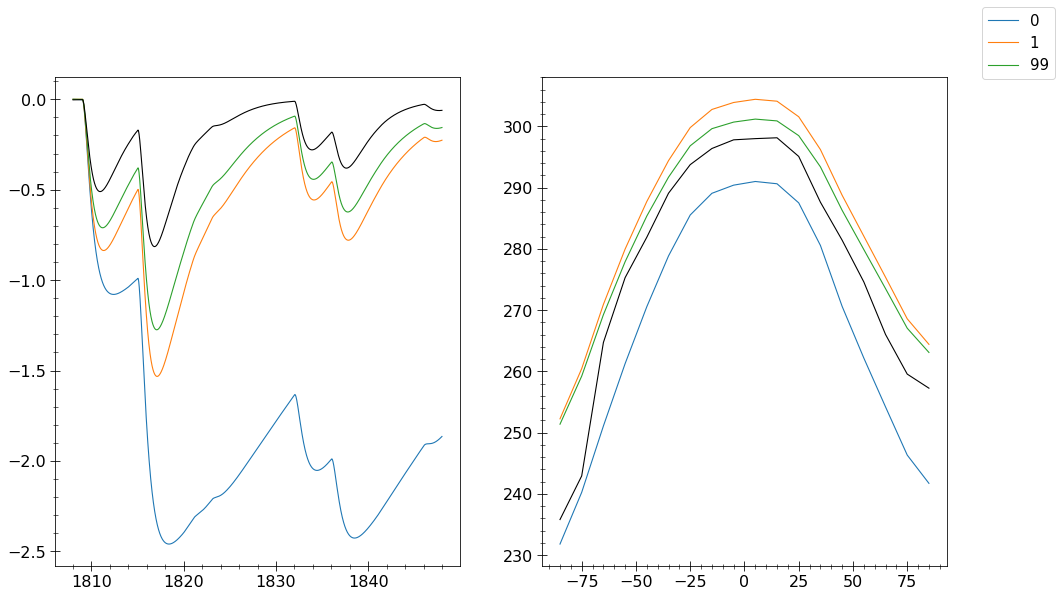

In [8]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
for i in [0,1,99]:
    ax[0].plot(Year_volc_1808_1858,data[1][i,0],label=i)
for i in [0,1,99]:
    ax[1].plot(Vars.Lat,data[0][i,0])
#plt.plot(Year_volc_1808_1858,data[1,1])
#plt.plot(Year_volc_1808_1858,data[1,2])
#plt.plot(Year_volc_1808_1858,data[1,3])
#plt.plot(Year_volc_1808_1858,data[1,4])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')
ax[1].plot(Lat_10,ZMT_10,c='k')
plt.figlegend(fontsize=15)
#plt.xlim(1808,1858)
print(gamma)

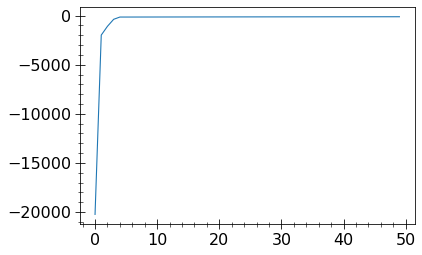

In [13]:
plt.plot(np.arange(50),dF[:,0])

In [31]:
print(gamma)
print(F)
print(dF)
print(P)

[1.00000000e-07 9.99972776e-08 7.96411807e-05 1.25390005e-04
 1.12720129e-04 1.10334142e-04 1.14971662e-04 1.10323682e-03]
[[4908.46279504 4907.68081928 4909.23973105 4895.28385247 4923.48298139
  4823.27040287 5054.43158254 4908.28522758 4908.63776618 4908.43195343
  4908.4941851  4907.80603045 4909.1303077 ]
 [1753.97298698 1753.97300141 1753.97298094 1754.48947943 1753.45663279
  1753.97427467 1753.97169816 1753.9730001  1753.97298007 1753.97303131
  1753.97294266 1753.97350971 1753.97247316]
 [1751.16403766 1751.16404821 1751.16402823 1751.67986844 1750.64831832
  1751.16532353 1751.16274737 1751.16404375 1751.16403319 1751.16407915
  1751.1639929  1751.16454727 1751.16352985]
 [ 276.06893623  276.0685077   276.0693672   276.25742215  275.88053744
   276.07116675  276.06670406  276.07005415  276.06781831  276.06927555
   276.0685969   276.07429964  276.06357283]
 [  90.3567686    90.35446318   90.35907689   90.33866833   90.37496561
    90.35391603   90.35962299   90.35721128   90.

In [18]:
print(70*4.2e6)

294000000.0


In [30]:
print(0.33*np.sum(((data[0][8,0]-target['ZMT'])*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2))
print(0.66*np.sum(((data[1][8,0]-target['GMT']))**2))

38.13576100244077
45.9309035943473


In [35]:
print(np.sqrt(np.dot(dF[-2],dF[-2])))
print(np.sqrt(np.dot(dF[0],dF[0])))

117.79102151319456
7220029.930903146


In [35]:
#setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
labels=[['eqparam','c_ao'],['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P=[3.02794273e+08, 4.80868504e-01, 2.47299528e-15, 1.16506701e+00,
 1.16500290e+00, 1.16499030e+00]
#P1=[2.10056979e+08, 5.00042362e-01, 2.01124229e-15, 1.16500050e+00,1.16500009e+00, 1.16500191e+00]
config_CTRL=importer('Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config_CTRL=add_parameters(config_CTRL,P,labels)
data_CTRL=rk4alg(model_equation,config_CTRL['eqparam'],config_CTRL['funccomp'],progressbar=True)
ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

config_base=importer('Dev_Data/Optimization/Volcanic_Sellers.ini')
variable_importer(config_base,initialZMT=False)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
config=add_parameters(config_base,P,labels)
Vars.T,Vars.T_global=ZMT,GMT   
data1=rk4alg(model_equation,config['eqparam'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Loading Configuration from: Dev_Data/Optimization/Volcanic_Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


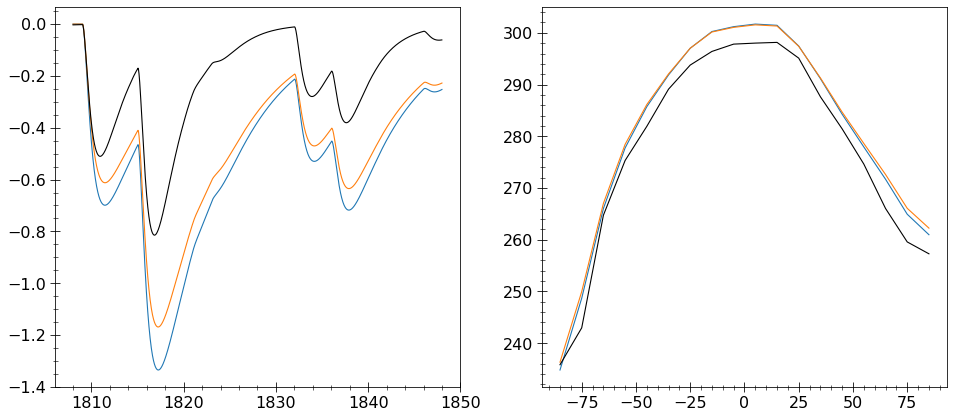

In [36]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
ax[0].plot(data[0]/constants.time_sec_year,data[2]-data[2][0])
ax[0].plot(data1[0]/constants.time_sec_year,data1[2]-data1[2][0])
ax[0].plot(Year_volc_1808_1858,EVA_GMT_1808_1858,c='k')

elevation=-0.0065*np.array(ParasCTRL[1][1])
ax[1].plot(Vars.Lat,data[1][0]+elevation)
ax[1].plot(Vars.Lat,data1[1][0]+elevation)
ax[1].plot(Lat_10,ZMT_10,c='k')

plt.savefig('Coupled_Optimization.eps',format='EPS')

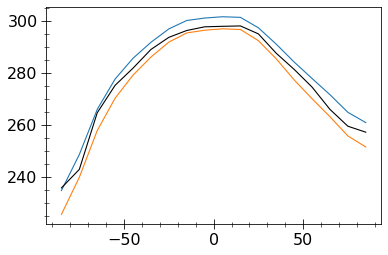

In [25]:
elevation=-0.0065*np.array(ParasCTRL[1][1])
plt.plot(Vars.Lat,data[1][0]+elevation)
plt.plot(Vars.Lat,data1[1][0]+elevation)
plt.plot(Lat_10,ZMT_10,c='k')